In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

SEQUENCE_LENGTH = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0
LEARNING_RATE = 0.001
EPOCHS = 100 
BATCH_SIZE = 32

In [13]:
df = pd.read_csv("merged_X142000101_v2.csv", parse_dates=["Date"], dayfirst=True)
df.set_index("Date", inplace=True)

df.head()

features = ['Ptot', 'Temp', 'E_PM', 'Humi', 'Vent', 'IHGR', 'SWI','TN','TX'] #peut etre d'autre features meilleur je c pas trop
target = 'niveau_nappe_eau'

df['y_lag_1'] = df[target].shift(1)
df = df.dropna()
X =df[features].values
#X = dX = np.concatenate(
 #   [df[features].values, df[['y_lag_1']].values],
#    axis=1
#)

y = df[target].values.reshape(-1, 1)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)  

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length ):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQUENCE_LENGTH)

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [14]:
class DualLSTM(nn.Module):
    def __init__(self, hidden_y, hidden_x, n_features):
        super().__init__()
        self.lstm_y = nn.LSTM(1, hidden_y, batch_first=True)
        self.lstm_x = nn.LSTM(n_features, hidden_x, batch_first=True)
        self.fc = nn.Linear(hidden_y + hidden_x, 1)

    def forward(self, y_seq, x_seq):
        _, (hy, _) = self.lstm_y(y_seq)
        _, (hx, _) = self.lstm_x(x_seq)
        return self.fc(torch.cat([hy[-1], hx[-1]], dim=1))


def build_dual_sequences(X, y, seq_len):
    X_seq, y_seq, y_target = [], [], []

    for t in range(seq_len, len(y)):
        X_seq.append(X[t-seq_len:t])
        y_seq.append(y[t-seq_len:t])
        y_target.append(y[t])

    return (
        np.array(y_seq),      # (N, L, 1)
        np.array(X_seq),      # (N, L, n_features)
        np.array(y_target)    # (N, 1)
    )

y_seq, X_seq, y_target = build_dual_sequences(X_scaled, y_scaled, SEQUENCE_LENGTH)

split = int(0.8 * len(y_seq))

y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_target[:split], y_target[split:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_seq_train_t = torch.FloatTensor(y_seq_train).to(device)
X_seq_train_t = torch.FloatTensor(X_seq_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device)

y_seq_test_t = torch.FloatTensor(y_seq_test).to(device)
X_seq_test_t = torch.FloatTensor(X_seq_test).to(device)
y_test_t = torch.FloatTensor(y_test).to(device)



In [28]:


class DualLSTMDataset(Dataset):
    def __init__(self, y_seq, X_seq, y_target):
        self.y_seq = y_seq
        self.X_seq = X_seq
        self.y_target = y_target

    def __len__(self):
        return len(self.y_target)

    def __getitem__(self, idx):
        return (
            self.y_seq[idx],     # (L, 1)
            self.X_seq[idx],     # (L, n_features)
            self.y_target[idx]   # (1,)
        )


BATCH_SIZE = 32

train_dataset = DualLSTMDataset(
    y_seq_train_t, X_seq_train_t, y_train_t
)

test_dataset = DualLSTMDataset(
    y_seq_test_t, X_seq_test_t, y_test_t
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("y_seq_train shape :", y_seq_train.shape)
print("X_seq_train shape :", X_seq_train.shape)
print("y_train shape     :", y_train.shape)

print("y_seq_test shape  :", y_seq_test.shape)
print("X_seq_test shape  :", X_seq_test.shape) 
print("y_test shape      :", y_test.shape)


y_seq_train shape : (5596, 7, 1)
X_seq_train shape : (5596, 7, 9)
y_train shape     : (5596, 1)
y_seq_test shape  : (1399, 7, 1)
X_seq_test shape  : (1399, 7, 9)
y_test shape      : (1399, 1)


In [16]:

model = DualLSTM(
    hidden_y=64,
    hidden_x=64,
    n_features=len(features) 
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=10, factor=0.5
)

EPOCHS = 100
best_val_loss = float("inf")
for epoch in range(EPOCHS):

    # ===== TRAIN =====
    model.train()
    train_loss = 0.0

    for y_seq, x_seq, y_true in train_loader:
        optimizer.zero_grad()

        y_pred = model(y_seq, x_seq)
        loss = criterion(y_pred, y_true)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for y_seq, x_seq, y_true in test_loader:
            y_pred = model(y_seq, x_seq)
            loss = criterion(y_pred, y_true)
            val_loss += loss.item()

    val_loss /= len(test_loader)

    scheduler.step(val_loss)

    # ===== CHECKPOINT =====
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_dual_lstm.pth")

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:03d} | "
            f"Train MSE: {train_loss:.4f} | "
            f"Val MSE: {val_loss:.4f}"
        )
model.load_state_dict(torch.load("best_dual_lstm.pth"))

Epoch 010 | Train MSE: 0.0100 | Val MSE: 0.0185
Epoch 020 | Train MSE: 0.0076 | Val MSE: 0.0191
Epoch 030 | Train MSE: 0.0060 | Val MSE: 0.0194
Epoch 040 | Train MSE: 0.0050 | Val MSE: 0.0195
Epoch 050 | Train MSE: 0.0046 | Val MSE: 0.0193
Epoch 060 | Train MSE: 0.0044 | Val MSE: 0.0195
Epoch 070 | Train MSE: 0.0043 | Val MSE: 0.0196
Epoch 080 | Train MSE: 0.0042 | Val MSE: 0.0196
Epoch 090 | Train MSE: 0.0042 | Val MSE: 0.0196
Epoch 100 | Train MSE: 0.0042 | Val MSE: 0.0197


<All keys matched successfully>

In [20]:
model.eval()

preds, trues = [], []

with torch.no_grad():
    for y_seq, X_seq, y_true in test_loader:
        y_seq = y_seq.to(device)     # (B, L, 1)
        X_seq = X_seq.to(device)     # (B, L, n_feat)
        y_true = y_true.to(device)   # (B, 1)

        y_pred = model(y_seq, X_seq) # (B, 1)

        preds.append(y_pred.cpu().numpy())
        trues.append(y_true.cpu().numpy())

preds = np.vstack(preds)
trues = np.vstack(trues)

# inverse scaling
preds_inv = scaler_y.inverse_transform(preds)
trues_inv = scaler_y.inverse_transform(trues)

# métriques
rmse = np.sqrt(mean_squared_error(trues_inv, preds_inv))
mae = mean_absolute_error(trues_inv, preds_inv)
r2 = r2_score(trues_inv, preds_inv)

print(f"One-step ahead — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


One-step ahead — RMSE: 0.0541, MAE: 0.0240, R2: 0.9839


Forecast 30 jours — RMSE: 0.1960, MAE: 0.1371, R2: 0.7826


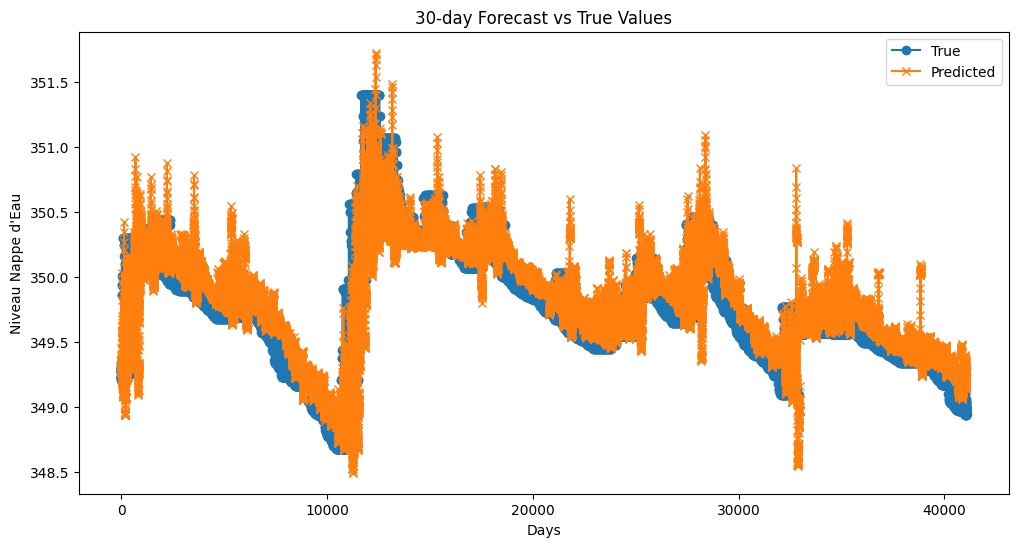

In [ ]:
def forecast_multi_horizon(
    model,
    y_init_seq,        # (L, 1) scaled
    X_future,          # (H, n_features) scaled
    scaler_y,
    device
):
    """
    Multi-step autoregressive forecast

    Returns:
        y_pred : (H, 1) in original scale
    """
    model.eval()

    L = y_init_seq.shape[0]
    H = X_future.shape[0]

    y_seq = y_init_seq.copy()
    preds_scaled = []

    for h in range(H):

        # construire la séquence X alignée sur y_seq
        if h < L:
            X_seq = X_future[:L]
        else:
            X_seq = X_future[h-L+1:h+1]

        y_tensor = torch.FloatTensor(y_seq).unsqueeze(0).to(device)
        X_tensor = torch.FloatTensor(X_seq).unsqueeze(0).to(device)

        with torch.no_grad():
            y_pred = model(y_tensor, X_tensor).cpu().numpy()[0, 0]

        preds_scaled.append(y_pred)

        # réinjection
        y_seq = np.vstack([y_seq[1:], [[y_pred]]])

    preds_scaled = np.array(preds_scaled).reshape(-1, 1)
    return scaler_y.inverse_transform(preds_scaled)


HORIZON = 30

preds_all, trues_all = [], []

for i in range(len(y_seq_test) - HORIZON):

    # dernière séquence connue
    y_init = y_seq_test[i]  # (L,1)

    # futures features connues
    X_future = X_seq_test[i:i+HORIZON, -1, :]  # (H,n_features)

    # prédiction multi-horizon
    y_pred = forecast_multi_horizon(
        model,
        y_init,
        X_future,
        scaler_y,
        device
    )

    # vérité terrain
    y_true = scaler_y.inverse_transform(
        y_test[i:i+HORIZON]
    )

    preds_all.append(y_pred[:, 0])
    trues_all.append(y_true[:, 0])

preds_all = np.array(preds_all)
trues_all = np.array(trues_all)

rmse = np.sqrt(mean_squared_error(trues_all.flatten(), preds_all.flatten()))
mae = mean_absolute_error(trues_all.flatten(), preds_all.flatten())
r2 = r2_score(trues_all.flatten(), preds_all.flatten())

print(f"Forecast {HORIZON} jours — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# plot forcast for all test samples
plt.figure(figsize=(12,6))
plt.plot(trues_all.flatten(), label="True", marker='o')
plt.plot(preds_all.flatten(), label="Predicted", marker='x')
plt.title(f"{HORIZON}-day Forecast vs True Values")
plt.xlabel("Days")
plt.ylabel("Niveau Nappe d'Eau")
plt.legend()
plt.show()

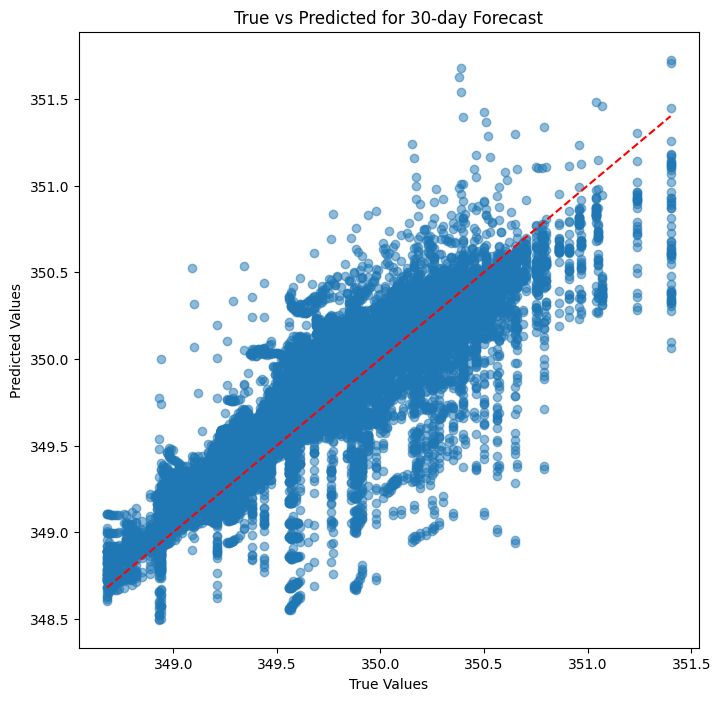

In [27]:
# true vs predicted plot
plt.figure(figsize=(8,8))
plt.scatter(trues_all.flatten(), preds_all.flatten(), alpha=0.5)
plt.plot(
    [trues_all.min(), trues_all.max()],
    [trues_all.min(), trues_all.max()],
    color='red',
    linestyle='--'
)
plt.title(f"True vs Predicted for {HORIZON}-day Forecast")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()